In [ ]:
#maybe try to create a new kernal
!nvidia-smi

In [ ]:
import sys
!{sys.executable} -m pip install pycuda pyopencl reikna 

In [ ]:
import sys
!{sys.executable} -m pip install numpy

# Pycuda and other GPGPU Libraries on the VACC
### If when running this code, an error returns that says 'INVALID DEVICE', restart the kernal and run the cell below.  This will likely happen when running different functions.

### MUST BE RUN ON DEEPGREEN

In [1]:
import os
import numpy as np
from scipy.signal import windows

import reikna.cluda as cluda
from reikna.fft import FFT, FFTShift
from reikna.linalg import EntrywiseNorm
from reikna.linalg import MatrixMul
from reikna.algorithms import Transpose
from reikna import transformations
from scipy.constants import pi
import matplotlib.pyplot as plt
import reikna.core as rcore
from pycuda import cumath

from scipy.signal import welch
from scipy.fftpack import fftshift
%config InlineBackend.figure_format = 'svg'
plt.style.use('notebook.mplstyle')
import time


def create_signal(length):
    Fs = 1/(10000)
    t = np.arange(0, length*Fs, Fs) # make it really big so we can see how fast the GPU is
    sig = np.cos(200*t + 0.6) + np.cos(300*t + 4.5)
    return sig.astype(np.complex64)


def load_data(fname,count=-1):
    data = np.fromfile(fname, dtype=np.complex64, count=count)
    powerof2 = np.log2(len(data))
    num_zeros = int(2**np.ceil(powerof2)) - len(data)
    the_zeros = np.zeros((num_zeros,)).astype(np.complex64)
    data_padded = np.concatenate((data, the_zeros))
    return data_padded


def rolling_frame(arr, NFFT, noverlap, pad_to):
    """
    Bogdan Opanchuk, May 5, 2015, Reikna, the pure Python GPGPU library
    https://github.com/fjarri/reikna
    
    Transforms a 1D array to a 2D array whose rows are
    partially overlapped parts of the initial array.
    """

    frame_step = NFFT - noverlap
    frame_num = (arr.size - noverlap) // frame_step
    frame_size = NFFT if pad_to is None else pad_to
    result_arr = rcore.Type(arr.dtype, (int(frame_num), int(frame_size)))

    return rcore.Transformation(
        [
            rcore.Parameter('output', rcore.Annotation(result_arr, 'o')),
            rcore.Parameter('input', rcore.Annotation(arr, 'i')),
        ],
        """
        %if NFFT != output.shape[1]:
        if (${idxs[1]} >= ${NFFT})
        {
            ${output.store_same}(0);
        }
        else
        %endif
        {
            ${output.store_same}(${input.load_idx}(${idxs[0]} * ${frame_step} + ${idxs[1]}));
        }
        """,
        render_kwds=dict(frame_step=int(frame_step), NFFT=NFFT),
        # note that only the "store_same"-using argument can serve as a connector!
        connectors=['output'])

def apply_window(arr, win, NFFT):
    result_arr = rcore.Type(arr.dtype, arr.shape)
    return rcore.Transformation(
        [
            rcore.Parameter('input', rcore.Annotation(arr,'i')),
            rcore.Parameter('window', rcore.Annotation(win,'i')),
            rcore.Parameter('output', rcore.Annotation(result_arr, 'o'))
        ],
    
        '''
        VSIZE_T idx = ${idxs[1]};
        ${output.store_same}(${mul}(${input.load_same},${window.load_idx}(idx)));
        
        ''',
        connectors=['input','window','output'],
        render_kwds=dict(mul=cluda.functions.mul(arr.dtype, win.dtype), NFFT=NFFT))


def shift_fft(arr, NFFT):
    """
    Thinking this might be faster than another computation since we dont have to compile again
    """
    return rcore.Transformation(
        [
            rcore.Parameter('input', rcore.Annotation(arr, 'i')),
            rcore.Parameter('output', rcore.Annotation(rcore.Type(np.float32, shape=(NFFT,)), 'o'))
        ],
        """
        VSIZE_T idx = ${idxs[0]};
        if (idx < ${NFFT}/2)
            ${output.store_idx}(${NFFT}/2 + idx, ${input.load_same});
        if (idx >= ${NFFT}/2)
            ${output.store_idx}(idx - ${NFFT}/2, ${input.load_same});

        """,
        connectors=['input','output'],
        render_kwds=dict(NFFT=NFFT))

    
class Compute_FFT_PSD(rcore.Computation):
    def __init__(self, x, fs, window, NFFT):
        
        assert x.dtype == np.complex64
        window_energy = np.sum(window**2).real
        rolling_frame_trf = rolling_frame(x, NFFT, NFFT/2, pad_to=None)
        
        in_type = rcore.Type(np.complex64, shape=rolling_frame_trf.output.shape)
        window_type = rcore.Type(np.complex64, shape=window.shape)
   
         # Define types for absolute transformation
        amp_type  = rcore.Type(np.float32, shape=rolling_frame_trf.output.shape) 
        
        abs_trf = transformations.norm_const(in_type, order=2) # Complex to mag transformation
        apply_window_trf = apply_window(rolling_frame_trf.output, window_type, NFFT)
        scale_power_trf = transformations.div_const(abs_trf.output, fs*window_energy) # to normalize FFT
        
       
        
        fft = FFT(in_type, axes=(1,)) # Adding transformations to computation
        fft.parameter.input.connect(
            apply_window_trf, apply_window_trf.output,
            non_windowed=apply_window_trf.input, window=apply_window_trf.window)
        fft.parameter.non_windowed.connect(    
            rolling_frame_trf, rolling_frame_trf.output, x_in=rolling_frame_trf.input)
        
        fft.parameter.output.connect(
            abs_trf, abs_trf.input, abs_power=abs_trf.output)
        fft.parameter.abs_power.connect(
            scale_power_trf, scale_power_trf.input, scaled_output=scale_power_trf.output)        
        
        N,M = scale_power_trf.output.shape
        
        out_type = rcore.Type(np.float32, shape=(NFFT,))
        complete_average_trf = transformations.div_const(out_type, N)
        fft_shift_trf = shift_fft(out_type, NFFT)
        
        averaged_fft = EntrywiseNorm(fft.parameter.scaled_output, order=1, axes=(0,)) # This will sum all rows 
        averaged_fft.parameter.output.connect(
            complete_average_trf, complete_average_trf.input, avg_out=complete_average_trf.output)
        averaged_fft.parameter.avg_out.connect(
            fft_shift_trf, fft_shift_trf.input, psd_out=fft_shift_trf.output)
        
        self._fft = fft
        self._averaged_fft = averaged_fft
        
        rcore.Computation.__init__(self, [
                rcore.Parameter('output', rcore.Annotation(averaged_fft.parameter.psd_out,'o')),
                rcore.Parameter('input', rcore.Annotation(fft.parameter.x_in,'i')),
                rcore.Parameter('win', rcore.Annotation(fft.parameter.window,'i'))
            ])
        # build plan is required for a computation, this function organizes kernel calls
        # to the CUDA API
    def _build_plan(self, plan_factory, device_params, output, input_, window):
        plan = plan_factory()
        temp = plan.temp_array_like(self._fft.parameter.scaled_output)
        plan.computation_call(self._fft, temp, input_, window)
        plan.computation_call(self._averaged_fft, output, temp)

        return plan

    
def comparison():
    signal = load_data('iq_data.bin')
    api = cluda.ocl_api()
    thr = api.Thread.create()


    NFFT=2**15
    win = windows.get_window('nuttall', NFFT).astype(np.complex64)
    fft_obj = Compute_FFT_PSD(x=signal, fs=10e6, window=win, NFFT=NFFT).compile(thr)
    
    x, win_device = thr.to_device(signal), thr.to_device(win)

    start = time.time()
   
    result = thr.empty_like(fft_obj.parameter.output)       
    fft_obj(result, x, win_device)
    fft_result = result.get()
    end = time.time()
    
    f,Pxx = welch(signal, fs=10e6, window=win, nperseg=NFFT, noverlap=NFFT/2, scaling='density')


    plt.plot((fftshift(10*np.log10(Pxx))))
    plt.plot(10*np.log10(fft_result))

    plt.show()
    
def benchmark_single_fft():
    expos = np.arange(4,27,1)
    powers_of_2 = 2**expos
    times = np.zeros((len(expos), 3))
    
    api = cluda.ocl_api()
    thr = api.Thread.create()

    for i, NFFT in enumerate(powers_of_2):
        
        signal = create_signal(NFFT)
        times[i,0] = NFFT
        win = windows.get_window('nuttall', NFFT).astype(np.complex64)
        fft_obj = Compute_FFT_PSD(x=signal, fs=10e6, window=win, NFFT=NFFT).compile(thr)
        x, win_device = thr.to_device(signal), thr.to_device(win)
        
        start = time.time()
        result = thr.empty_like(fft_obj.parameter.output)       
        fft_obj(result, x, win_device)
        fft_result = result.get()
        end = time.time()
        times[i,1] = end-start
        
        start = time.time()
        f,Pxx = welch(signal, fs=10e6, window=win, nperseg=NFFT, noverlap=NFFT/2, scaling='density')
        end = time.time()
        times[i,2] = end-start
    plt.semilogy(np.log2(times[:,0]), times[:,1], label='GPU Time')
    plt.semilogy(np.log2(times[:,0]), times[:,2], label='CPU Time')
    plt.legend()
    plt.xlabel('FFT Size (power of 2)')
    plt.ylabel('Computation Time (s)')
    plt.savefig('times.png', format='png')
    plt.grid()
    plt.show()

def benchmark_PSD():
    expos = np.arange(4,20,1)
    powers_of_2 = 2**expos
    times = np.zeros((len(expos), 3))
    
    api = cluda.ocl_api()
    thr = api.Thread.create()
    signal = load_data('iq_data.bin')
    print(len(signal))
    for i, NFFT in enumerate(powers_of_2):
        
        times[i,0] = NFFT
        win = windows.get_window('nuttall', NFFT).astype(np.complex64)
        fft_obj = Compute_FFT_PSD(x=signal, fs=10e6, window=win, NFFT=NFFT).compile(thr)
        x, win_device = thr.to_device(signal), thr.to_device(win)
        
        start = time.time()
        result = thr.empty_like(fft_obj.parameter.output)       
        fft_obj(result, x, win_device)
        fft_result = result.get()
        end = time.time()
        times[i,1] = end-start
        
        start = time.time()
        f,Pxx = welch(signal, fs=10e6, window=win, nperseg=NFFT, noverlap=NFFT/2, scaling='density')
        end = time.time()
        times[i,2] = end-start
    plt.semilogy(np.log2(times[:,0]), times[:,1], label='GPU Time')
    plt.semilogy(np.log2(times[:,0]), times[:,2], label='CPU Time')
    plt.legend()
    plt.xlabel('FFT Size (power of 2)')
    plt.ylabel('Computation Time (s)')
    plt.xlim([3,20])
    plt.savefig('times_welch.png', format='png')
    plt.grid()
    plt.show()

def compare_fft_sizes():
    api = cluda.ocl_api()
    thr = api.Thread.create()
    
    expos = np.arange(21,9,-3)
    powers_of_2 = 2**expos
    signal = load_data('iq_data.bin')
    for i, NFFT in enumerate(powers_of_2):
        
        win = windows.get_window('nuttall', NFFT).astype(np.complex64)
        fft_obj = Compute_FFT_PSD(x=signal, fs=10e6, window=win, NFFT=NFFT).compile(thr)
        x, win_device = thr.to_device(signal), thr.to_device(win)
        
        result = thr.empty_like(fft_obj.parameter.output)       
        fft_obj(result, x, win_device)
        fft_result = result.get()
        freq = np.linspace(95-5, 95+5, len(fft_result))
        plt.plot(freq, 10*np.log10(fft_result), label=f'NFFT = {NFFT}')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('PSD (dB)')
    plt.legend(loc=(1,0))
    plt.savefig('gpuwelch_fft_size_comparison.png', format='png')
    plt.show()

def compare_plots():
    api = cluda.ocl_api()
    thr = api.Thread.create()
    
    NFFT_list = [2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
    signal = load_data('iq_data.bin')
    fig, axes = plt.subplots(2,3, figsize=(12,10), sharex=True)
    for i, ax in enumerate(axes.flat):
        NFFT = NFFT_list[i]
        win = windows.get_window('nuttall', NFFT).astype(np.complex64)
        fft_obj = Compute_FFT_PSD(x=signal, fs=10e6, window=win, NFFT=NFFT).compile(thr)
        x, win_device = thr.to_device(signal), thr.to_device(win)
        
        result = thr.empty_like(fft_obj.parameter.output)       
        fft_obj(result, x, win_device)
        fft_result = result.get()
        freq = np.linspace(95-5, 95+5, len(fft_result))
        ax.plot(freq, 10*np.log10(fft_result), label='Reikna')
        
        f,Pxx = welch(signal, fs=10e6, window=win, nperseg=NFFT, noverlap=NFFT/2, scaling='density')
        ax.plot(freq,10*np.log10(fftshift(Pxx)), ls='--', label='Scipy')
        ax.set_title(f'NFFT={NFFT}')
        
    [ax.set_ylabel('PSD (dB)') for ax in axes[:,0]]
    [ax.set_xlabel('Frequency (MHz)') for ax in axes[-1,:]]
    axes[0,2].legend(loc=(1,0), fontsize=20)
    plt.show()
    fig.savefig('welch_v_gpu.png', format='png')

def grav_wave_psd():

    NFFT = 4096
    fs = 16384
    fname = 'data/H-H1_GWOSC_16KHZ_R1-1187006835-4096.txt'
    print(f'Loading data of size {os.path.getsize(fname)/ 1e6} MB')
    s = time.time()
    grav_signal = np.loadtxt(fname, comments='#').astype(np.complex64)*10e19
    e = time.time()
    print(f'Time to load data of size {os.path.getsize(fname)/ 1e6} MB: {e-s} s')
    api = cluda.ocl_api()
    thr = api.Thread.create()

    win = windows.get_window('nuttall', NFFT).astype(np.complex64)
    s = time.time()
    grav_psd_gpu = Compute_FFT_PSD(x=grav_signal, fs=fs, window=win, NFFT=NFFT).compile(thr) 
    x, win_device = thr.to_device(grav_signal), thr.to_device(win)
    result = thr.empty_like(grav_psd_gpu.parameter.output)       
    grav_psd_gpu(result, x, win_device)
    grav_psd_res = result.get()
    e = time.time()
    print(f'Time to calculate PSD on GPU: {e-s} s')
    freq = np.linspace(-fs/2, fs/2, NFFT)
    s = time.time()
    f,Pxx = welch(grav_signal, fs=16384, window=win, nperseg=NFFT, noverlap=NFFT/2, scaling='density')
    e = time.time()
    print(f'Time to calculate PSD with SciPy welch: {e-s} s')
    plt.loglog(freq, grav_psd_res)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Scaled Power')
    plt.grid()
    plt.savefig('grav_psd.png', format='png')
    

    plt.show()

def main():
    pass
    
if __name__ == '__main__':
    main()

## Compare to Scipy's Welch Function (verify my computation works)

/gpfs1/arch/spack-0.12.0-1/opt/spack/linux-rhel7-x86_64/gcc-7.3.0/python-3.6.5-virw5ivp6rthnxug2uegbv52qjm3adhk/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


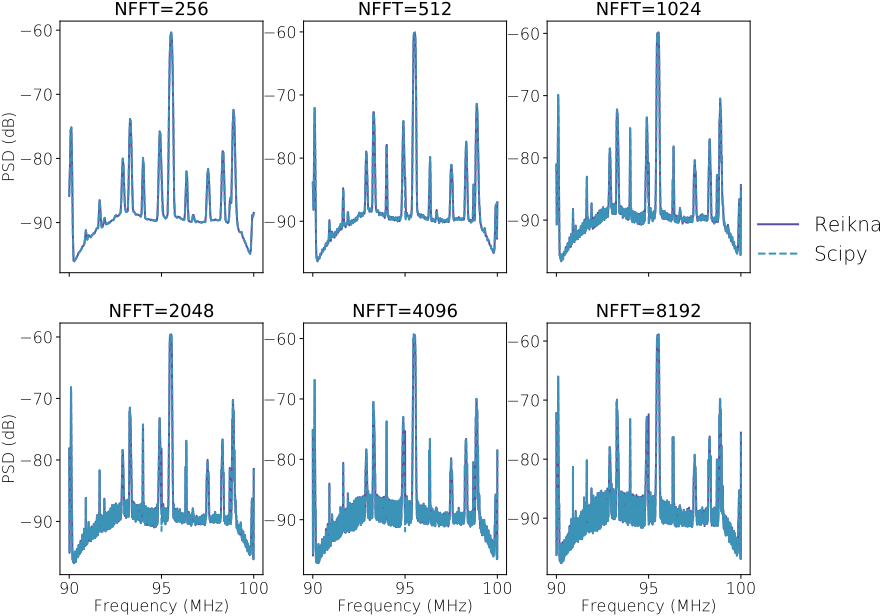

In [5]:
compare_plots()

## Show different FFT sizes using welch function

/gpfs1/arch/spack-0.12.0-1/opt/spack/linux-rhel7-x86_64/gcc-7.3.0/py-ipykernel-4.5.0-jotl465bgyc5yr4eeewjpeeqb774jdpr/lib/python2.7/site-packages/ipykernel/__main__.py:289: RuntimeWarning: divide by zero encountered in log10


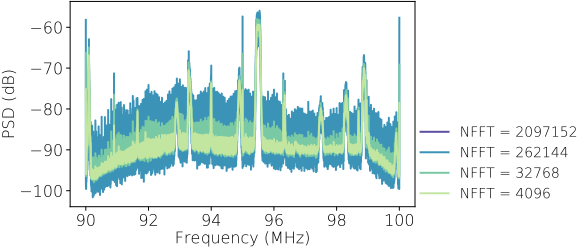

In [16]:
compare_fft_sizes()

/gpfs1/arch/spack-0.12.0-1/opt/spack/linux-rhel7-x86_64/gcc-7.3.0/python-3.6.5-virw5ivp6rthnxug2uegbv52qjm3adhk/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


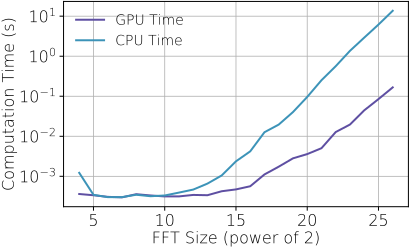

In [2]:
benchmark_single_fft()

## Compare the times of Scipy's Welch and Compute_FFT_PSD

2097152


/gpfs1/arch/spack-0.12.0-1/opt/spack/linux-rhel7-x86_64/gcc-7.3.0/python-3.6.5-virw5ivp6rthnxug2uegbv52qjm3adhk/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


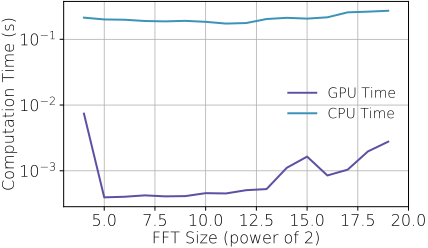

In [2]:
benchmark_PSD()

In [ ]:
from scipy.signal import welch
from scipy.fftpack import fftshift
import time

data = np.fromfile('iq_data.bin', dtype=np.complex64, count=2**20)
powerof2 = np.log2(len(data))
num_zeros = int(2**np.ceil(powerof2)) - len(data)
the_zeros = np.zeros((num_zeros,)).astype(np.complex64)
data_padded = np.concatenate((data, the_zeros))
NFFT = 2**15
start = time.time()
f,Pxx = welch(data_padded, fs=10e6, window='nuttall', nperseg=NFFT, noverlap=NFFT/2)
end = time.time()
print(end-start)
plt.plot(f,fft_shift(10*np.log10(Pxx)))
plt.show()

## Compare Scipy's Welch to Compute_FFT_PSD

Loading data of size 1577.059731 MB
Time to load data of size 1577.059731 MB: 451.0486786365509 s
Time to calculate PSD on GPU: 0.3127610683441162 s


/gpfs1/arch/spack-0.12.0-1/opt/spack/linux-rhel7-x86_64/gcc-7.3.0/python-3.6.5-virw5ivp6rthnxug2uegbv52qjm3adhk/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


Time to calculate PSD with SciPy welch: 6.439516067504883 s


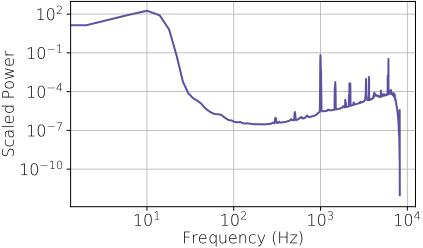

In [2]:
grav_wave_psd()

## Windowing demonstration for report

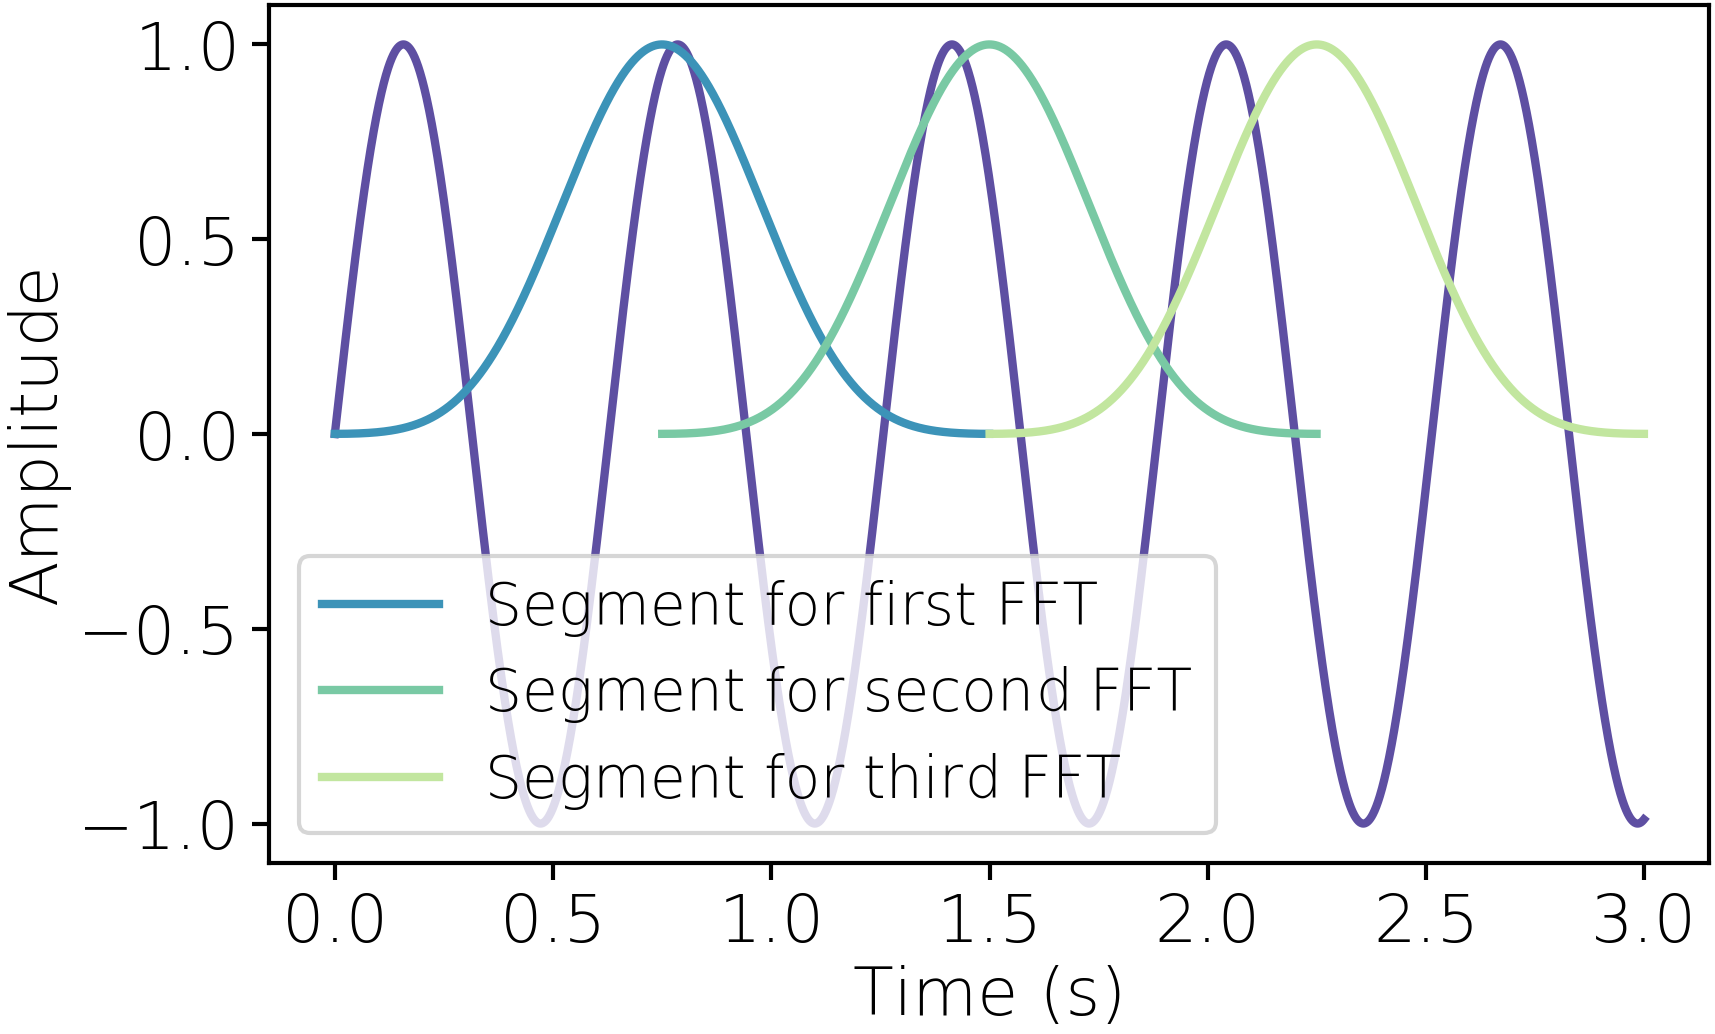

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import windows
plt.style.use('notebook.mplstyle')

win = windows.nuttall(1500)
t = np.arange(0,3, 1/1000)

f = np.sin(10*t)
plt.plot(t,f)
plt.plot(t[0:1500], win, label='Segment for first FFT')
plt.plot(t[750:2250], win, label='Segment for second FFT')
plt.plot(t[1500:3000], win, label='Segment for third FFT')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(frameon=True)



plt.show()